In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score

import pandas as pd

from timeit import default_timer as timer
from datetime import timedelta
import matplotlib.pyplot as plt

import re

import torch

from torch.utils.data import Dataset

In [ ]:
torch.cuda.is_available()

False

In [ ]:
torch.cuda.is_available()

False

In [ ]:
# model_name = "xlm-roberta-base"
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

# La librería cargará automáticamente el modelo en PyTorch
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
config = AutoConfig.from_pretrained(model_name) # used for id to label name
model = AutoModelForSequenceClassification.from_pretrained(model_name)

NUM_LABELS = 3  # Tienes 3 clases: 0, 1, 2 (o Positivo, Neutral, Negativo)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Master Seminario 2/data_extended.csv" # Cambia esto a la ruta de tu archivo
# DATA_PATH = "./data_extended.csv"
df= pd.read_csv(DATA_PATH)
df.head()

,Unnamed: 0,full_text,POS,clean_text,label,text_changed
0,0,"Sin ser fan de Juan Gabriel, siempre supe que ...",P,fan juan gabriel supe fuerza naturaleza escuch...,2,fan juan gabriel supe naturaleza escuche quer...
1,1,Sabes que no tendrás un buen día cuando lo pri...,N,tendras ana tratar cambiar foco cae cara,0,tendras ana tratar cambiar foco cae caradura
2,2,"En situaciones en las que no sepas que hacer, ...",N,situaciones sepas sumergete podras escuchar al...,0,situaciones situaciones sepas sumergete podra...
3,3,ayer preguntaban y dónde están las solteras!!!...,NEU,preguntaban solteras grupo alza mano unica vol...,1,preguntaban solteras grupo alza alza alza man...
4,4,Que el finde sea para hacer cualquier cosa que...,NEU,finde cosa haga feliz reverenda gana,1,finde elemento haga feliz reverenda gana


In [ ]:
Random_state = 20
# stratified_sample = df.groupby('label').apply(lambda x: x.sample(frac=0.5, random_state=Random_state))

df = df.sample(frac=1, random_state = Random_state)

In [ ]:
df_w = df[["label", "full_text"]]

In [ ]:
df_w['full_text'] = df_w['full_text'].str.lower()
df_w["full_text"] = df_w["full_text"].str.replace(r'\s*https?://\S+(\s+|$)', ' ').str.strip()
df_w['full_text'] = df_w['full_text'].str.replace(
    r'[^a-z0-9\s]',
    '',
    regex=True,
    flags=re.IGNORECASE
)

df_w = df_w.dropna()

/tmp/ipython-input-1665169174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w['full_text'] = df_w['full_text'].str.lower()
/tmp/ipython-input-1665169174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w["full_text"] = df_w["full_text"].str.replace(r'\s*https?://\S+(\s+|$)', ' ').str.strip()
/tmp/ipython-input-1665169174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [ ]:
df_w.shape

(36211, 2)

In [ ]:
for column in df_w.columns:
    if column == "full_text":
        df_w = df_w.rename(columns={"full_text":"text_changed"})
    else:
        pass
## Cambiar aca, SOLO si usas "SIN preprocess", sino, ignorar

In [ ]:
if 'label' not in df_w.columns or 'text_changed' not in df_w.columns:
    raise ValueError("El DataFrame debe contener las columnas 'text' y 'label'.")

In [ ]:
# label_map = {label: i for i, label in enumerate(df_w['label'].unique())}
# df_w['label'] = df_w['label'].map(label_map)

In [ ]:
df_train = df_w[:22000]
df_val = df_w[22000:30000]
df_test = df_w[30000:]

train_texts = df_train['text_changed'].tolist()
train_labels = df_train['label'].tolist()

val_texts = df_val['text_changed'].tolist()
val_labels = df_val['label'].tolist()

test_texts = df_test['text_changed'].tolist()
test_labels = df_test['label'].tolist()

In [ ]:
# train_texts, val_texts, train_labels, val_labels = train_test_split(
#     df_w['text_changed'].tolist(),
#     df_w['label'].tolist(),
#     test_size=0.38,
#     # random_state=2,
#     #stratify=df['label'] # Asegura una distribución equilibrada de clases
# )

# val_texts, test_texts, val_labels, test_labels = train_test_split(val_texts,
#                                                                   val_labels,
#                                                                   test_size = 0.4,
#                                                                   # random_state = 42,  ## Shuffle del dS
#                                                                  )

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
seqlen = df_w['text_changed'].apply(lambda x: len(x.split()))
max_len = seqlen.max()

In [ ]:


class SentimentDataset(Dataset):
    """Clase personalizada para manejar la tokenización y PyTorch"""
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt' # Devuelve tensores de PyTorch
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# 3. Crear instancias de Dataset
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

In [ ]:
def compute_metrics(p):
    """Calcula la exactitud y el F1-Score (Macro)"""
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_score(p.label_ids, preds)
    # F1-Macro es mejor para clasificación multi-clase
    f1 = f1_score(p.label_ids, preds, average='macro')
    return {"accuracy": acc, "f1_macro": f1}

In [ ]:
# 4. Argumentos de Entrenamiento
# Puedes ajustar estos hiperparámetros según tus recursos (GPU)
training_args = TrainingArguments(
    output_dir="./xlm_roberta_sentiment_results",  # Directorio para guardar el modelo
    num_train_epochs=5,                          # Número de épocas
    per_device_train_batch_size=16,              # Tamaño del batch por dispositivo (ajusta si tienes poca VRAM)
    per_device_eval_batch_size=32,
    # warmup_steps=500,                            # Pasos de calentamiento para el scheduler
    weight_decay=0.01,                           # Regularización
    logging_dir='./logs',                        # Directorio de logs
    logging_steps=50,
    eval_strategy="epoch",                 # Evaluar al final de cada época
    save_strategy="epoch",                       # Guardar checkpoint al final de cada época
    load_best_model_at_end=True,                 # Cargar el mejor modelo guardado
    metric_for_best_model="f1_macro",            # Criterio para el mejor modelo
    # Puedes ajustar la tasa de aprendizaje si el modelo diverge
    learning_rate=5e-5,
)

In [ ]:
# 5. Inicializar el modelo para clasificación
# AutoModelForSequenceClassification agrega una capa de clasificación
# lineal encima de XLM-R, lista para el fine-tuning.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS
)

# optimizer = Adam(learning_rate=2e-5)
# loss = SparseCategoricalCrossentropy(from_logits=True)

# model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [ ]:
# 6. Inicializar el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# 7. Ejecutar el Fine-Tuning
print("Iniciando el Fine-Tuning...")
start = timer()
trainer.train()
end = timer()
train_time = timedelta(seconds=end-start) ##
print("Training for 3 classes on Peruvian DS with XLMT NOpreprocesado: ", timedelta(seconds=end-start))

Iniciando el Fine-Tuning...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: msvf96 (msvf96-universidad-nacional-de-san-agustin-de-arequipa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.226900,0.255567,0.939000,0.933629
2,0.095300,0.114532,0.975750,0.974545
3,0.072700,0.061093,0.987000,0.986231
4,0.025600,0.038152,0.992500,0.992177
5,0.016700,0.028389,0.993875,0.993700


Training for 3 classes on Peruvian DS with XLMT NOpreprocesado:  0:59:20.428818


In [ ]:
print("Fine-Tuning Completado. Evaluando el mejor modelo...")
# Mostrar las métricas finales en el conjunto de validación
final_metrics = trainer.evaluate()
print(f"Métricas Finales en Validación: {final_metrics}")

Fine-Tuning Completado. Evaluando el mejor modelo...


Métricas Finales en Validación: {'eval_loss': 0.028388703241944313, 'eval_accuracy': 0.993875, 'eval_f1_macro': 0.9936998254340992, 'eval_runtime': 49.2104, 'eval_samples_per_second': 162.567, 'eval_steps_per_second': 5.08, 'epoch': 5.0}


In [ ]:
trainer.save_model("/content/drive/MyDrive/Master Seminario 2/final_twitter_xlm_roberta_sentiment_model_2_NoPre")
tokenizer.save_pretrained("/content/drive/MyDrive/Master Seminario 2/final_twitter_xlm_roberta_sentiment_model_2_NoPre")

print("Modelo guardado en /content/drive/MyDrive/Master Seminario 2/final_twitter_xlm_roberta_sentiment_model_2_NoPre")


Modelo guardado en /content/drive/MyDrive/final_twitter_xlm_roberta_sentiment_model_2_NoPre


In [ ]:
# 8. Guardar el modelo final
trainer.save_model("./final_twitter_xlm_roberta_sentiment_model_2_NoPre")
tokenizer.save_pretrained("./final_twitter_xlm_roberta_sentiment_model_2_NoPre")

print("Modelo guardado en ./final_twitter_xlm_roberta_sentiment_model_2_NoPre")

Modelo guardado en ./final_twitter_xlm_roberta_sentiment_model_2_NoPre


In [ ]:
trainer = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/final_twitter_xlm_roberta_sentiment_model_2_NoPre")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/final_twitter_xlm_roberta_sentiment_model_2_NoPre")

In [ ]:
minimal_training_args = TrainingArguments(
    output_dir="./tmp_predict_output",
    per_device_eval_batch_size=32, # Use a larger batch size for faster prediction
)

In [ ]:
new_trainer = Trainer(
    model=trainer,
    args=minimal_training_args,
    # No need for train_dataset or compute_metrics for simple prediction
)

In [ ]:
start_time = timer()
y_logits = new_trainer.predict(test_dataset)
test_time = timer() - start_time

# Evaluación
print("test_time in seconds", test_time)

classification_report = classification_report(test_labels, y_logits[1])

print(classification_report)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: msvf96 (msvf96-universidad-nacional-de-san-agustin-de-arequipa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


test_time in seconds 2953.1393482850003
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2813
           1       1.00      1.00      1.00      1567
           2       1.00      1.00      1.00      1831

    accuracy                           1.00      6211
   macro avg       1.00      1.00      1.00      6211
weighted avg       1.00      1.00      1.00      6211



In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report

# tokens = tokenizer(
#     list(df_test["text_changed"]),
#     padding="max_length",
#     truncation=True,
#     max_length=128,
#     return_tensors="np"
# )

# test_dataset = tf.data.Dataset.from_tensor_slices((
#     {
#         "input_ids": tf.convert_to_tensor(tokens["input_ids"]),
#         "attention_mask": tf.convert_to_tensor(tokens["attention_mask"])
#     },
#     tf.convert_to_tensor(df_test["label"].values)
# )).batch(48)

# Predicción
start_time = timer()
y_logits = trainer.predict(test_dataset)
test_time = timer() - start_time
# Evaluación
print("test_time in seconds", test_time)

classification_report = classification_report(test_labels, y_logits[1])

print(classification_report)

test_time in seconds 38.29829024999981
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2813
           1       1.00      1.00      1.00      1567
           2       1.00      1.00      1.00      1831

    accuracy                           1.00      6211
   macro avg       1.00      1.00      1.00      6211
weighted avg       1.00      1.00      1.00      6211



In [ ]:
# test_labels

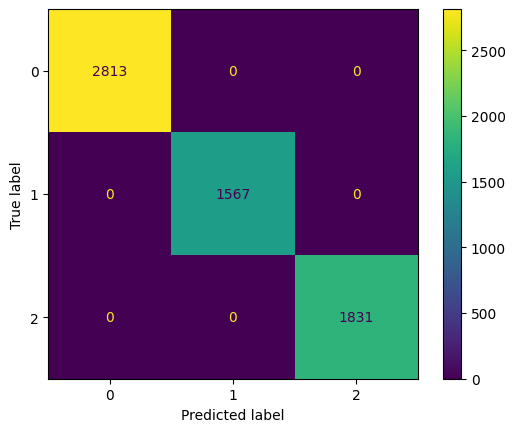

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy

confusion_matrix = confusion_matrix(test_labels, y_logits[1])

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()